# Emergency Room Patient Volume Prediction

This project aims to predict emergency room patient volume 4 hours in advance using machine learning techniques.

**Target Metrics:**
- MAPE < 20%
- MAE < 3 patients
- R² > 0.70

## Table of Contents
1. Data Loading and Preparation
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Model Training
5. Performance Evaluation
6. Predictions Visualization

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('husl')

## 1. Data Loading and Preparation

In [2]:
def generate_synthetic_er_data(start_date='2022-01-01', end_date='2024-01-01'):
    """
    Generate synthetic emergency room data with realistic patterns
    """
    # Create datetime index
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    n_hours = len(date_range)
    
    # Initialize dataframe
    df = pd.DataFrame(index=date_range)
    df['datetime'] = date_range
    df['hour'] = df.datetime.dt.hour
    df['day_of_week'] = df.datetime.dt.dayofweek
    df['month'] = df.datetime.dt.month
    df['day_of_year'] = df.datetime.dt.dayofyear
    
    # Create holiday indicators (simplified)
    holidays = [
        '2022-01-01', '2022-07-04', '2022-12-25', '2022-11-24',  # 2022
        '2023-01-01', '2023-07-04', '2023-12-25', '2023-11-23',  # 2023
        '2024-01-01'  # 2024
    ]
    df['is_holiday'] = df.datetime.dt.date.astype(str).isin(holidays).astype(int)
    
    # Weekend indicator
    df['is_weekend'] = (df.day_of_week >= 5).astype(int)
    
    # Day type
    df['day_type'] = 'weekday'
    df.loc[df.is_weekend == 1, 'day_type'] = 'weekend'
    df.loc[df.is_holiday == 1, 'day_type'] = 'holiday'
    
    # Weather data (synthetic)
    # Temperature with seasonal variation
    df['temperature'] = 20 + 15 * np.sin(2 * np.pi * df.day_of_year / 365) + np.random.normal(0, 5, n_hours)
    
    # Rain probability (higher in winter months)
    rain_prob = 0.3 + 0.2 * np.sin(2 * np.pi * (df.day_of_year + 90) / 365)
    df['is_raining'] = (np.random.random(n_hours) < rain_prob).astype(int)
    
    # Rainfall amount (when raining)
    df['rainfall_mm'] = np.where(df.is_raining, np.random.exponential(5, n_hours), 0)
    
    # Generate patient counts with realistic patterns
    base_patients = 8  # Base patient count per hour
    
    # Hourly patterns (higher during day, lower at night)
    hourly_multiplier = 1 + 0.5 * np.sin(2 * np.pi * (df.hour - 6) / 24)
    hourly_multiplier = np.maximum(hourly_multiplier, 0.5)  # Minimum 50% of base
    
    # Day of week patterns (higher on weekends)
    dow_multiplier = np.where(df.is_weekend, 1.3, 1.0)
    
    # Holiday patterns (higher on holidays)
    holiday_multiplier = np.where(df.is_holiday, 1.5, 1.0)
    
    # Weather impact (more patients when it's very hot/cold or raining)
    temp_impact = 1 + 0.1 * np.abs(df.temperature - 22) / 10  # Discomfort increases patients
    rain_impact = 1 + 0.2 * df.is_raining  # Rain increases accidents
    
    # Seasonal patterns (flu season in winter)
    seasonal_multiplier = 1 + 0.3 * np.maximum(0, np.cos(2 * np.pi * df.day_of_year / 365))
    
    # Combine all factors
    expected_patients = (base_patients * 
                        hourly_multiplier * 
                        dow_multiplier * 
                        holiday_multiplier * 
                        temp_impact * 
                        rain_impact * 
                        seasonal_multiplier)
    
    # Add random noise
    df['patient_count'] = np.random.poisson(expected_patients)
    
    # Ensure minimum of 1 patient per hour
    df['patient_count'] = np.maximum(df['patient_count'], 1)
    
    return df

# Generate the data
print("Generating synthetic emergency room data...")
df = generate_synthetic_er_data()
print(f"Generated {len(df)} hourly records from {df.datetime.min()} to {df.datetime.max()}")
print(f"Data shape: {df.shape}")
df.head()

Generating synthetic emergency room data...
Generated 17521 hourly records from 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Data shape: (17521, 12)


,datetime,hour,day_of_week,month,day_of_year,is_holiday,is_weekend,day_type,temperature,is_raining,rainfall_mm,patient_count
2022-01-01 00:00:00,2022-01-01 00:00:00,0,5,1,1,1,1,holiday,22.741771,1,6.229618,16
2022-01-01 01:00:00,2022-01-01 01:00:00,1,5,1,1,1,1,holiday,19.566879,0,0.000000,8
2022-01-01 02:00:00,2022-01-01 02:00:00,2,5,1,1,1,1,holiday,23.496643,0,0.000000,12
2022-01-01 03:00:00,2022-01-01 03:00:00,3,5,1,1,1,1,holiday,27.873350,1,5.839960,22
2022-01-01 04:00:00,2022-01-01 04:00:00,4,5,1,1,1,1,holiday,19.087433,0,0.000000,11


In [3]:
# Basic data info
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17521 entries, 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Freq: h
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       17521 non-null  datetime64[ns]
 1   hour           17521 non-null  int32         
 2   day_of_week    17521 non-null  int32         
 3   month          17521 non-null  int32         
 4   day_of_year    17521 non-null  int32         
 5   is_holiday     17521 non-null  int64         
 6   is_weekend     17521 non-null  int64         
 7   day_type       17521 non-null  object        
 8   temperature    17521 non-null  float64       
 9   is_raining     17521 non-null  int64         
 10  rainfall_mm    17521 non-null  float64       
 11  patient_count  17521 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(5), int64(3), object(1)
memory usage: 1.4+ MB
None

Basic Statistics:
     

## 2. Exploratory Data Analysis (EDA)

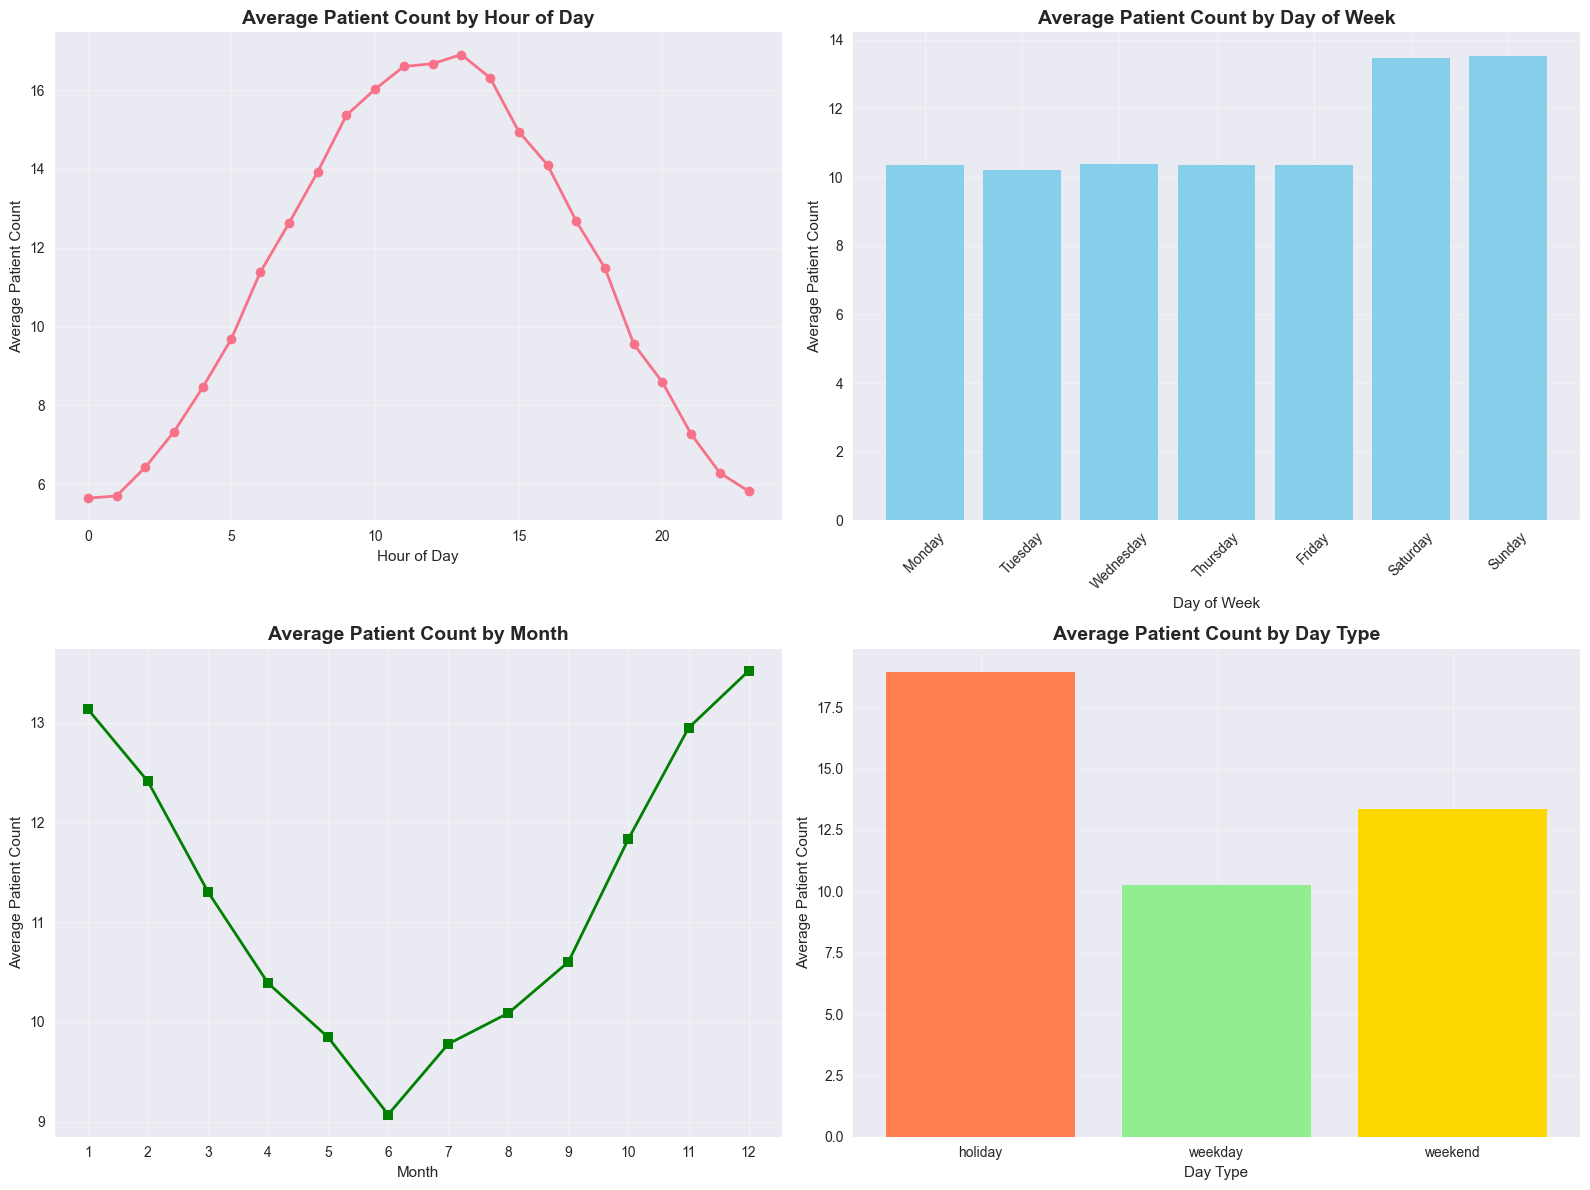

In [4]:
# Hourly patient trends
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hourly patterns
hourly_avg = df.groupby('hour')['patient_count'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0, 0].set_title('Average Patient Count by Hour of Day', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Average Patient Count')
axes[0, 0].grid(True, alpha=0.3)

# Day of week patterns
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df.groupby('day_of_week')['patient_count'].mean()
axes[0, 1].bar(range(7), dow_avg.values, color='skyblue')
axes[0, 1].set_title('Average Patient Count by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Patient Count')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_names, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Monthly patterns
monthly_avg = df.groupby('month')['patient_count'].mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='s', linewidth=2, color='green')
axes[1, 0].set_title('Average Patient Count by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Patient Count')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# Day type comparison
daytype_avg = df.groupby('day_type')['patient_count'].mean()
axes[1, 1].bar(daytype_avg.index, daytype_avg.values, color=['coral', 'lightgreen', 'gold'])
axes[1, 1].set_title('Average Patient Count by Day Type', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day Type')
axes[1, 1].set_ylabel('Average Patient Count')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

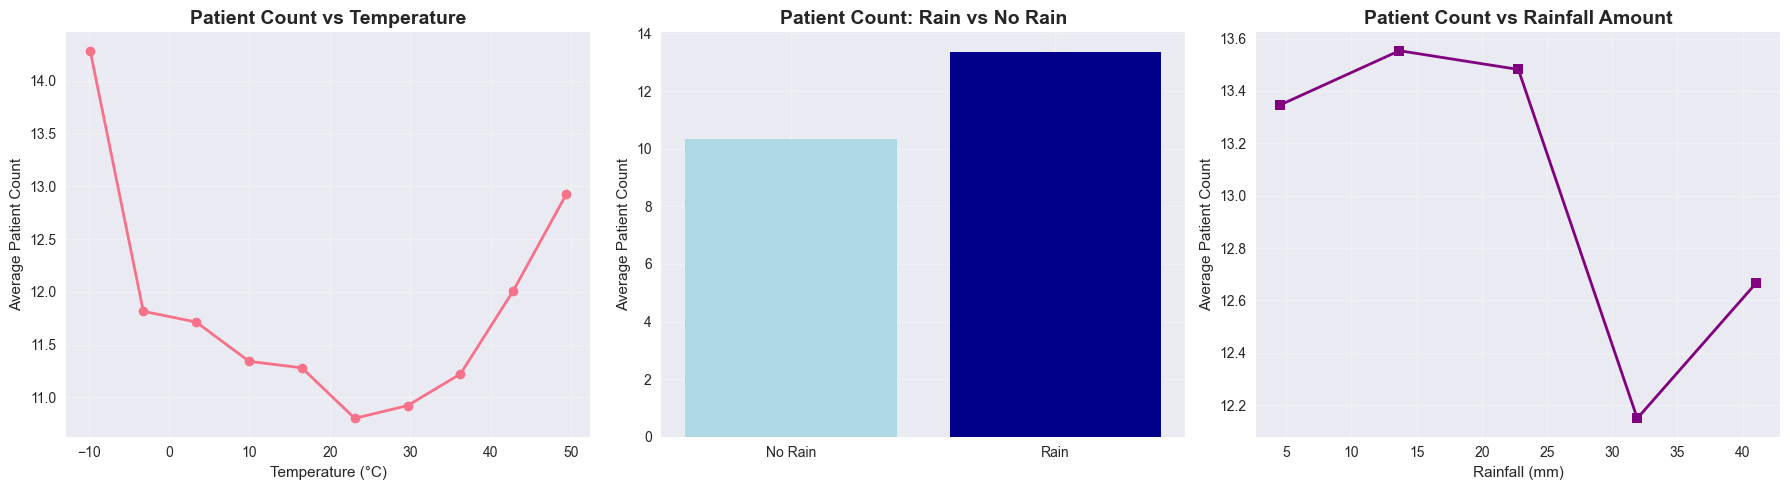

In [5]:
# Weather impact analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature vs patient count
temp_bins = pd.cut(df['temperature'], bins=10)
temp_avg = df.groupby(temp_bins)['patient_count'].mean()
temp_centers = [interval.mid for interval in temp_avg.index]
axes[0].plot(temp_centers, temp_avg.values, marker='o', linewidth=2)
axes[0].set_title('Patient Count vs Temperature', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Average Patient Count')
axes[0].grid(True, alpha=0.3)

# Rain impact
rain_impact = df.groupby('is_raining')['patient_count'].mean()
axes[1].bar(['No Rain', 'Rain'], rain_impact.values, color=['lightblue', 'darkblue'])
axes[1].set_title('Patient Count: Rain vs No Rain', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Patient Count')
axes[1].grid(True, alpha=0.3)

# Rainfall amount impact (when raining)
rainy_data = df[df['is_raining'] == 1]
if len(rainy_data) > 0:
    rainfall_bins = pd.cut(rainy_data['rainfall_mm'], bins=5)
    rainfall_avg = rainy_data.groupby(rainfall_bins)['patient_count'].mean()
    rainfall_centers = [interval.mid for interval in rainfall_avg.index]
    axes[2].plot(rainfall_centers, rainfall_avg.values, marker='s', linewidth=2, color='purple')
    axes[2].set_title('Patient Count vs Rainfall Amount', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Rainfall (mm)')
    axes[2].set_ylabel('Average Patient Count')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

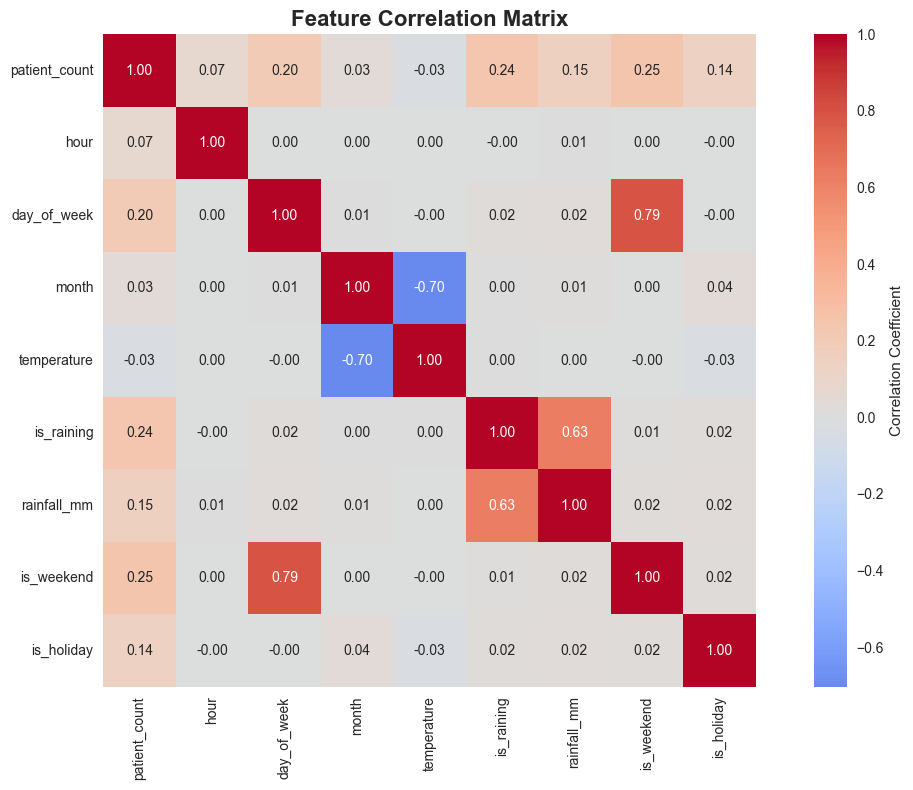

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_cols = ['patient_count', 'hour', 'day_of_week', 'month', 'temperature', 
                   'is_raining', 'rainfall_mm', 'is_weekend', 'is_holiday']
correlation_matrix = df[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

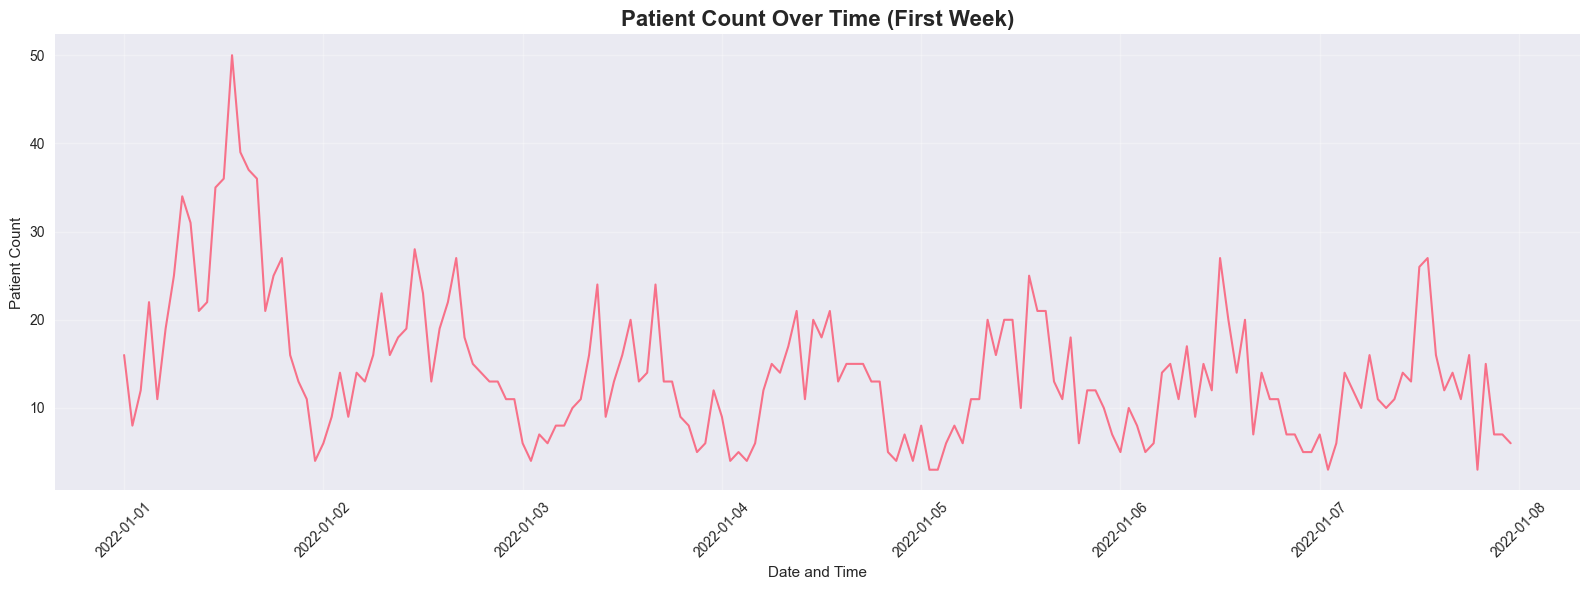

In [7]:
# Time series plot
plt.figure(figsize=(16, 6))
sample_data = df.iloc[:24*7]  # First week
plt.plot(sample_data['datetime'], sample_data['patient_count'], linewidth=1.5)
plt.title('Patient Count Over Time (First Week)', fontsize=16, fontweight='bold')
plt.xlabel('Date and Time')
plt.ylabel('Patient Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [8]:
def create_features(df):
    """
    Create additional features for the model
    """
    df = df.copy()
    
    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lag features (historical patient counts)
    for lag in [1, 2, 4, 6, 12, 24, 48, 168]:  # 1h, 2h, 4h, 6h, 12h, 1d, 2d, 1w
        df[f'patient_count_lag_{lag}h'] = df['patient_count'].shift(lag)
    
    # Rolling statistics
    for window in [6, 12, 24, 48]:
        df[f'patient_count_rolling_mean_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).mean()
        df[f'patient_count_rolling_std_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).std()
        df[f'patient_count_rolling_max_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).max()
        df[f'patient_count_rolling_min_{window}h'] = df['patient_count'].rolling(window=window, min_periods=1).min()
    
    # Weather interaction features
    df['temp_squared'] = df['temperature'] ** 2
    df['temp_deviation'] = np.abs(df['temperature'] - 22)  # Deviation from comfortable temp
    df['rain_temp_interaction'] = df['is_raining'] * df['temperature']
    
    # Time-based features
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    df['is_morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['is_evening_rush'] = ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    
    # Create target variable (patient count 4 hours later)
    df['target'] = df['patient_count'].shift(-4)
    
    return df

# Apply feature engineering
print("Creating features...")
df_features = create_features(df)
print(f"Features created. New shape: {df_features.shape}")

# Remove rows with missing target values
df_features = df_features.dropna(subset=['target'])
print(f"After removing missing targets: {df_features.shape}")

# Display feature list
feature_cols = [col for col in df_features.columns if col not in ['datetime', 'patient_count', 'target', 'day_type']]
print(f"\nTotal features: {len(feature_cols)}")
print("Feature columns:")
for i, col in enumerate(feature_cols):
    print(f"{i+1:2d}. {col}")

Creating features...
Features created. New shape: (17521, 50)
After removing missing targets: (17517, 50)

Total features: 46
Feature columns:
 1. hour
 2. day_of_week
 3. month
 4. day_of_year
 5. is_holiday
 6. is_weekend
 7. temperature
 8. is_raining
 9. rainfall_mm
10. hour_sin
11. hour_cos
12. day_of_week_sin
13. day_of_week_cos
14. month_sin
15. month_cos
16. patient_count_lag_1h
17. patient_count_lag_2h
18. patient_count_lag_4h
19. patient_count_lag_6h
20. patient_count_lag_12h
21. patient_count_lag_24h
22. patient_count_lag_48h
23. patient_count_lag_168h
24. patient_count_rolling_mean_6h
25. patient_count_rolling_std_6h
26. patient_count_rolling_max_6h
27. patient_count_rolling_min_6h
28. patient_count_rolling_mean_12h
29. patient_count_rolling_std_12h
30. patient_count_rolling_max_12h
31. patient_count_rolling_min_12h
32. patient_count_rolling_mean_24h
33. patient_count_rolling_std_24h
34. patient_count_rolling_max_24h
35. patient_count_rolling_min_24h
36. patient_count_rolli

In [9]:
# Check for remaining missing values and handle them
print("Missing values in features:")
missing_values = df_features[feature_cols].isnull().sum()
missing_features = missing_values[missing_values > 0]
print(missing_features)

# Fill missing values with appropriate methods
if len(missing_features) > 0:
    # Fill missing lag features with rolling means
    for col in missing_features.index:
        if 'lag' in col:
            df_features[col] = df_features[col].fillna(df_features['patient_count_rolling_mean_24h'])
        elif 'rolling_std' in col:
            df_features[col] = df_features[col].fillna(0)
        else:
            df_features[col] = df_features[col].fillna(df_features[col].mean())
    
    print("\nMissing values after filling:")
    print(df_features[feature_cols].isnull().sum().sum())

print(f"\nFinal dataset shape: {df_features.shape}")
print(f"Target variable stats:")
print(df_features['target'].describe())

Missing values in features:
patient_count_lag_1h               1
patient_count_lag_2h               2
patient_count_lag_4h               4
patient_count_lag_6h               6
patient_count_lag_12h             12
patient_count_lag_24h             24
patient_count_lag_48h             48
patient_count_lag_168h           168
patient_count_rolling_std_6h       1
patient_count_rolling_std_12h      1
patient_count_rolling_std_24h      1
patient_count_rolling_std_48h      1
dtype: int64

Missing values after filling:
0

Final dataset shape: (17517, 50)
Target variable stats:
count    17517.000000
mean        11.238911
std          5.798518
min          1.000000
25%          7.000000
50%         10.000000
75%         15.000000
max         50.000000
Name: target, dtype: float64


## 4. Model Training

In [10]:
# Prepare data for modeling
X = df_features[feature_cols].copy()
y = df_features['target'].copy()
dates = df_features['datetime'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Time-based split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training period: {dates_train.min()} to {dates_train.max()}")
print(f"Test period: {dates_test.min()} to {dates_test.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled.")

Feature matrix shape: (17517, 46)
Target vector shape: (17517,)

Training set: 14013 samples
Test set: 3504 samples
Training period: 2022-01-01 00:00:00 to 2023-08-07 20:00:00
Test period: 2023-08-07 21:00:00 to 2023-12-31 20:00:00
Features scaled.


In [11]:
# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'MAPE': mape}

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Train models and store results
results = {}
predictions = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    # Store results
    results[name] = {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics
    }
    predictions[name] = y_pred_test
    
    print(f"  Train - MAE: {train_metrics['MAE']:.2f}, RMSE: {train_metrics['RMSE']:.2f}, R²: {train_metrics['R²']:.3f}, MAPE: {train_metrics['MAPE']:.1f}%")
    print(f"  Test  - MAE: {test_metrics['MAE']:.2f}, RMSE: {test_metrics['RMSE']:.2f}, R²: {test_metrics['R²']:.3f}, MAPE: {test_metrics['MAPE']:.1f}%")
    print()

print("Model training completed!")

Training models...

Training Linear Regression...
  Train - MAE: 2.82, RMSE: 3.63, R²: 0.601, MAPE: 35.7%
  Test  - MAE: 2.97, RMSE: 3.82, R²: 0.589, MAPE: 35.8%

Training Random Forest...
  Train - MAE: 1.05, RMSE: 1.36, R²: 0.944, MAPE: 13.4%
  Test  - MAE: 2.98, RMSE: 3.87, R²: 0.577, MAPE: 35.5%

Training XGBoost...
  Train - MAE: 1.77, RMSE: 2.30, R²: 0.840, MAPE: 23.8%
  Test  - MAE: 3.10, RMSE: 3.99, R²: 0.551, MAPE: 36.7%

Model training completed!


## 5. Performance Evaluation

In [12]:
# Create performance comparison table
performance_data = []
for name, result in results.items():
    test_metrics = result['test_metrics']
    performance_data.append({
        'Model': name,
        'MAE': test_metrics['MAE'],
        'RMSE': test_metrics['RMSE'],
        'R²': test_metrics['R²'],
        'MAPE (%)': test_metrics['MAPE']
    })

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.round(3)

print("Model Performance Comparison (Test Set):")
print("=" * 60)
print(performance_df.to_string(index=False))
print("\nTarget Metrics:")
print("- MAE < 3.0")
print("- RMSE: Lower is better")
print("- R² > 0.70")
print("- MAPE < 20%")

# Check which models meet target criteria
print("\nModels meeting target criteria:")
for _, row in performance_df.iterrows():
    meets_criteria = (row['MAE'] < 3.0) & (row['R²'] > 0.70) & (row['MAPE (%)'] < 20)
    status = "✓" if meets_criteria else "✗"
    print(f"{status} {row['Model']}")

Model Performance Comparison (Test Set):
            Model   MAE  RMSE    R²  MAPE (%)
Linear Regression 2.968 3.816 0.589    35.813
    Random Forest 2.982 3.871 0.577    35.471
          XGBoost 3.101 3.989 0.551    36.697

Target Metrics:
- MAE < 3.0
- RMSE: Lower is better
- R² > 0.70
- MAPE < 20%

Models meeting target criteria:
✗ Linear Regression
✗ Random Forest
✗ XGBoost


Best performing model: Linear Regression
Test MAE: 2.97
Test R²: 0.589
Test MAPE: 35.8%


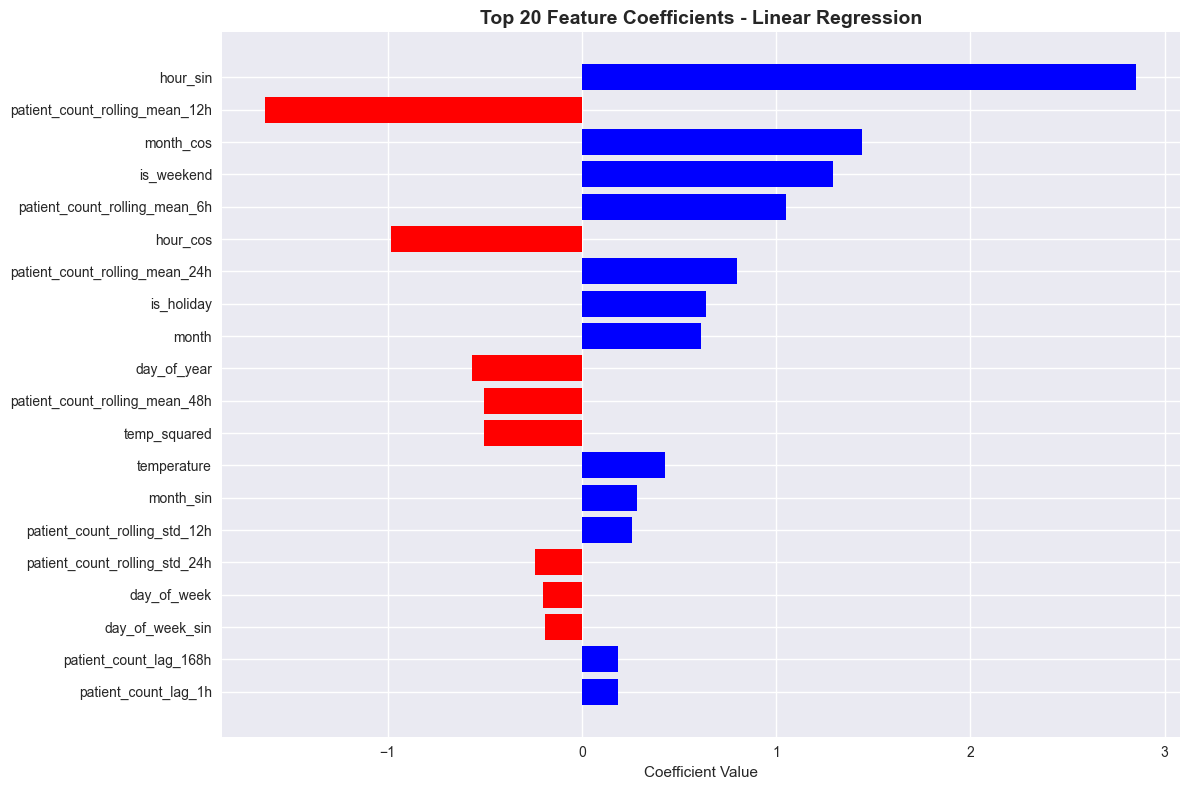

In [13]:
# Feature importance analysis
# Get the best performing model (lowest MAE)
best_model_name = performance_df.loc[performance_df['MAE'].idxmin(), 'Model']
best_model = results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")
print(f"Test MAE: {results[best_model_name]['test_metrics']['MAE']:.2f}")
print(f"Test R²: {results[best_model_name]['test_metrics']['R²']:.3f}")
print(f"Test MAPE: {results[best_model_name]['test_metrics']['MAPE']:.1f}%")

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i, (_, row) in enumerate(top_features.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']}: {row['importance']:.4f}")
elif best_model_name == 'Linear Regression':
    # For linear regression, show coefficients
    feature_coef = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    plt.figure(figsize=(12, 8))
    top_features = feature_coef.head(20)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 6. Predictions Visualization

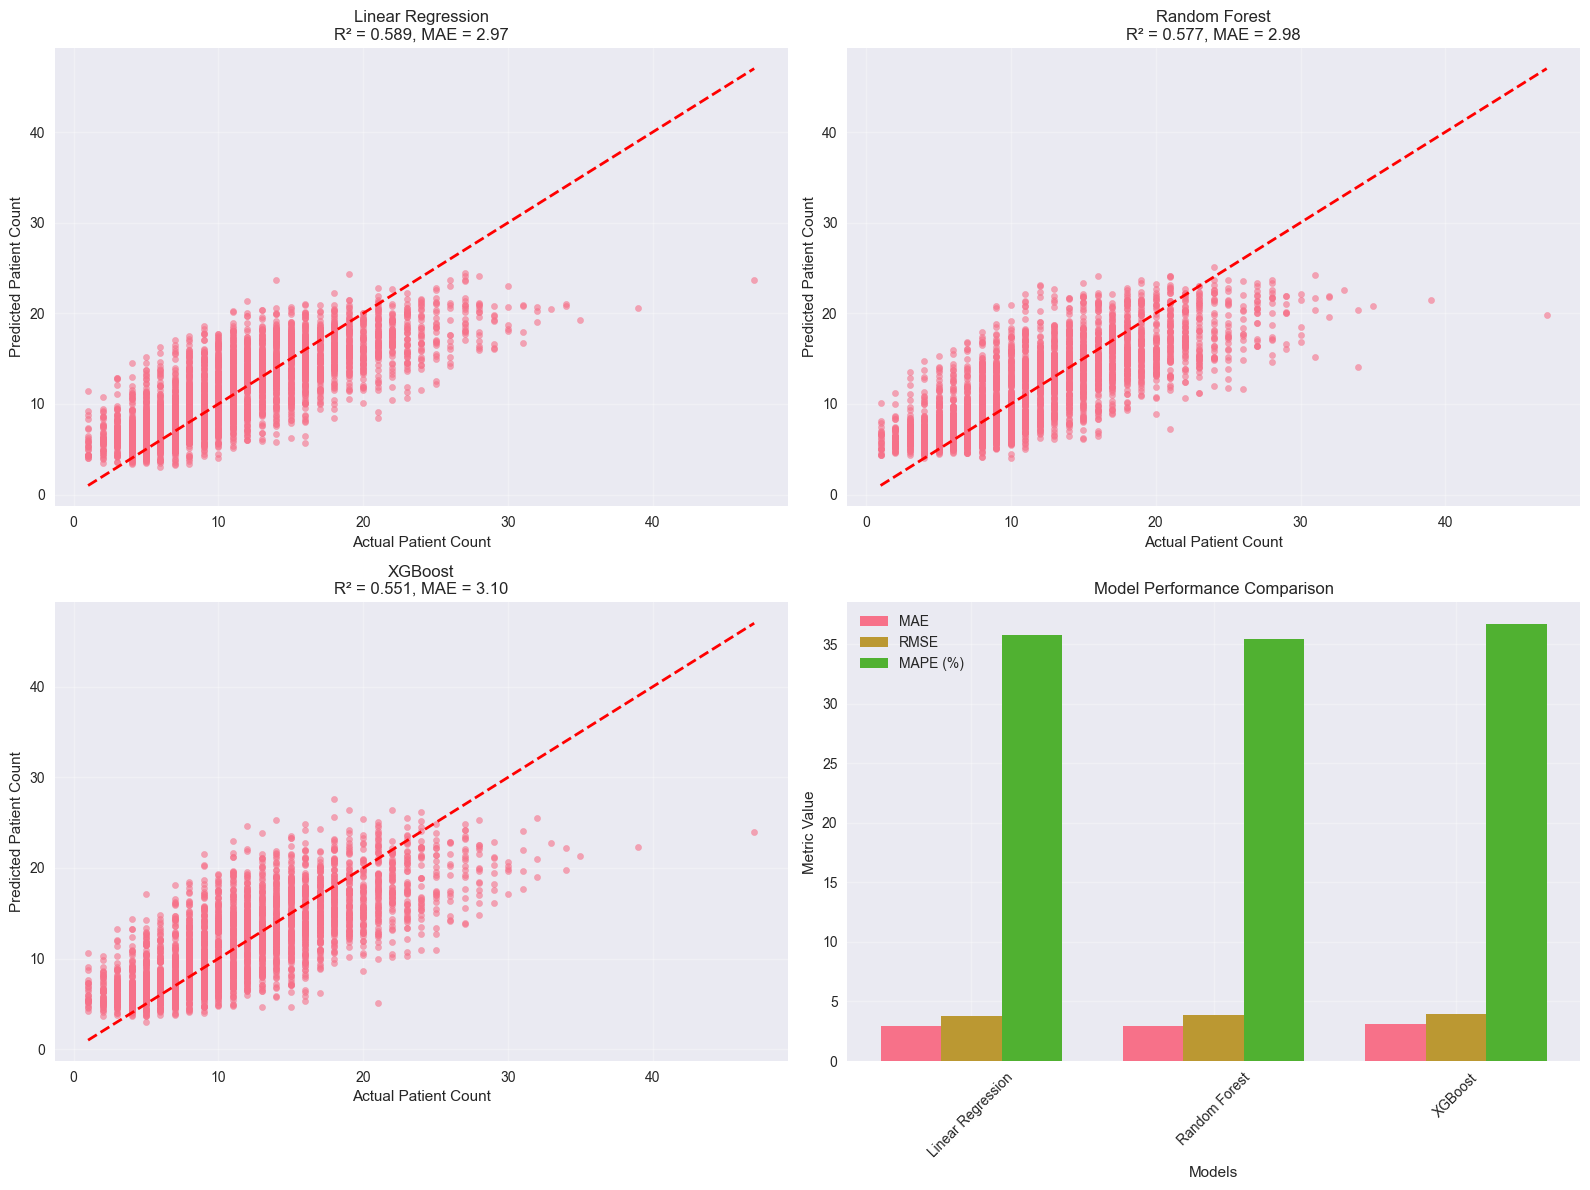

In [14]:
# Model predictions vs actual values
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# Plot for each model
for i, (name, pred) in enumerate(predictions.items()):
    if i < 3:  # Only plot first 3 models
        axes[i].scatter(y_test, pred, alpha=0.6, s=20)
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
        axes[i].set_xlabel('Actual Patient Count')
        axes[i].set_ylabel('Predicted Patient Count')
        axes[i].set_title(f'{name}\nR² = {results[name]["test_metrics"]["R²"]:.3f}, MAE = {results[name]["test_metrics"]["MAE"]:.2f}')
        axes[i].grid(True, alpha=0.3)

# Performance comparison bar chart
metrics_to_plot = ['MAE', 'RMSE', 'MAPE (%)']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    values = [performance_df[performance_df['Model'] == name][metric].iloc[0] for name in models.keys()]
    axes[3].bar(x + i*width, values, width, label=metric)

axes[3].set_xlabel('Models')
axes[3].set_ylabel('Metric Value')
axes[3].set_title('Model Performance Comparison')
axes[3].set_xticks(x + width)
axes[3].set_xticklabels(models.keys(), rotation=45)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

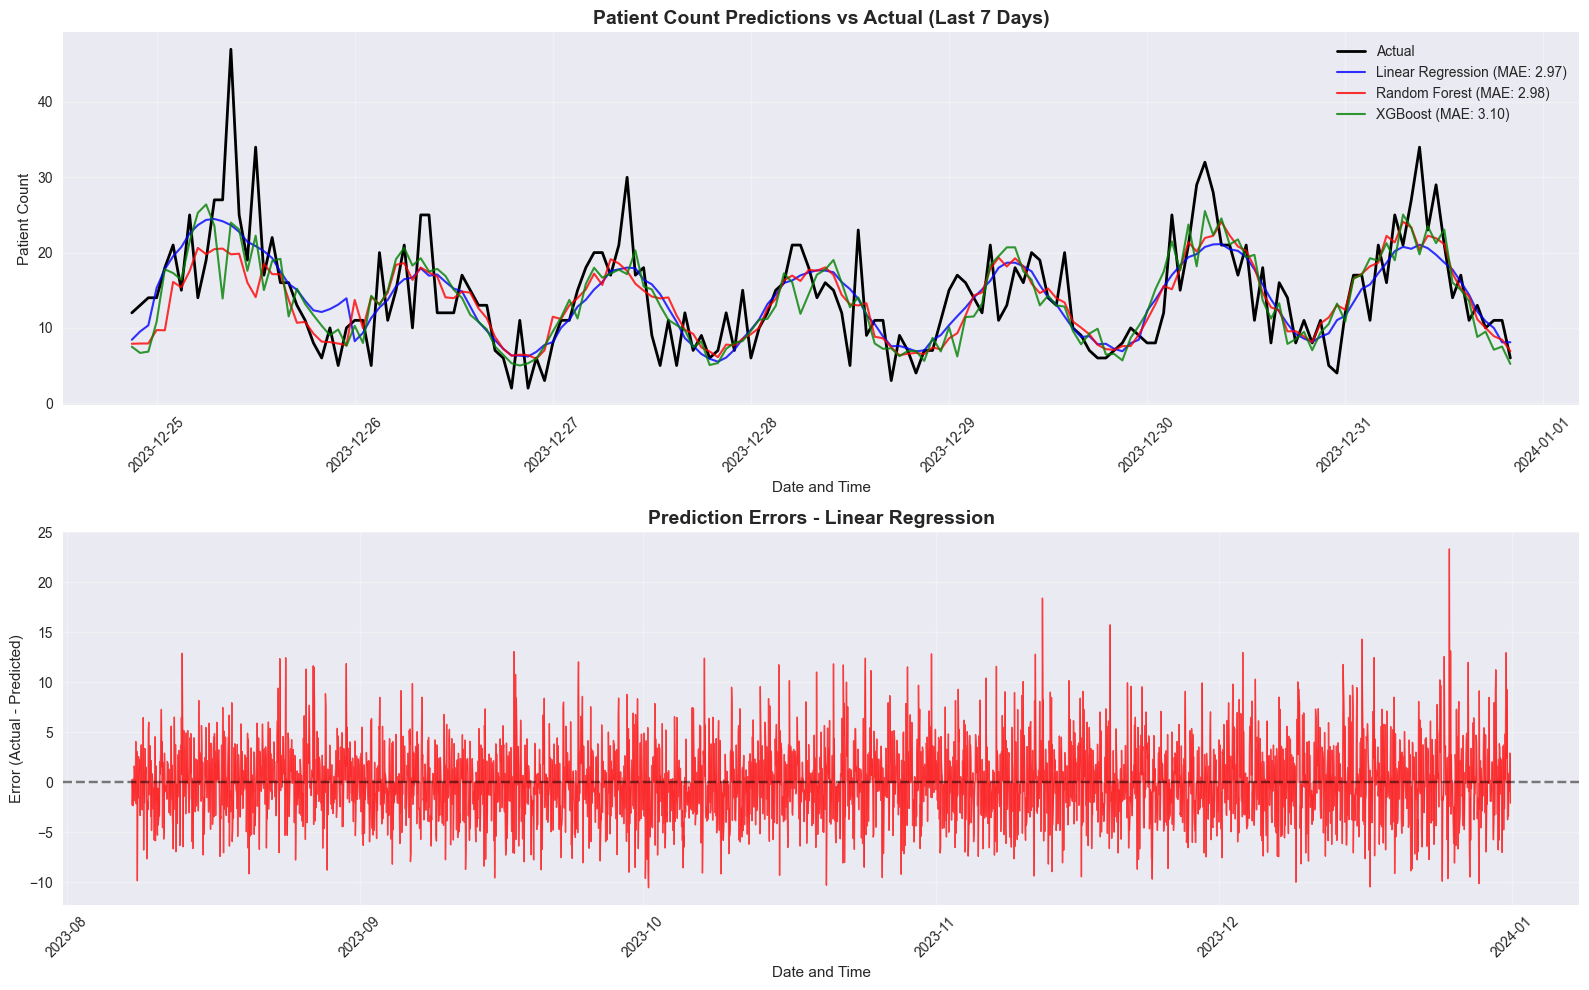

In [15]:
# Time series prediction visualization
plt.figure(figsize=(16, 10))

# Show last 7 days of test data
last_week_idx = -24*7  # Last 7 days
dates_plot = dates_test.iloc[last_week_idx:]
actual_plot = y_test.iloc[last_week_idx:]

plt.subplot(2, 1, 1)
plt.plot(dates_plot, actual_plot, label='Actual', linewidth=2, color='black')

colors = ['blue', 'red', 'green']
for i, (name, pred) in enumerate(predictions.items()):
    pred_plot = pred[last_week_idx:]
    plt.plot(dates_plot, pred_plot, label=f'{name} (MAE: {results[name]["test_metrics"]["MAE"]:.2f})', 
             linewidth=1.5, alpha=0.8, color=colors[i])

plt.title('Patient Count Predictions vs Actual (Last 7 Days)', fontsize=14, fontweight='bold')
plt.xlabel('Date and Time')
plt.ylabel('Patient Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Error analysis
plt.subplot(2, 1, 2)
best_pred = predictions[best_model_name]
errors = y_test - best_pred
plt.plot(dates_test, errors, alpha=0.7, color='red', linewidth=1)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.fill_between(dates_test, errors, alpha=0.3, color='red')
plt.title(f'Prediction Errors - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Date and Time')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

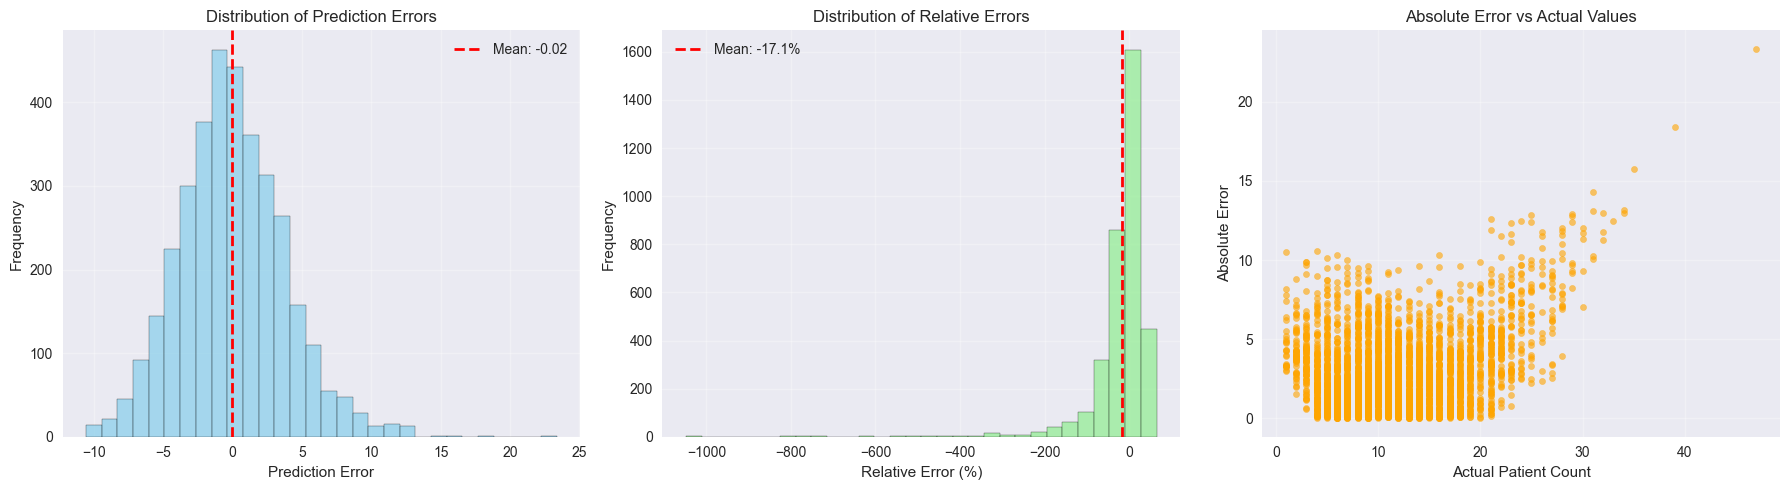

Error Statistics for Linear Regression:
Mean Error: -0.02
Standard Deviation of Errors: 3.82
Mean Absolute Error: 2.97
95% of errors within: ±7.61
Percentage of predictions within ±2 patients: 42.3%
Percentage of predictions within ±3 patients: 58.8%


In [16]:
# Error distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

best_pred = predictions[best_model_name]
errors = y_test - best_pred
relative_errors = errors / y_test * 100

# Error histogram
axes[0].hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(errors.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Relative error histogram
axes[1].hist(relative_errors, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(relative_errors.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {relative_errors.mean():.1f}%')
axes[1].set_xlabel('Relative Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Relative Errors')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Error vs actual values
axes[2].scatter(y_test, np.abs(errors), alpha=0.6, s=20, color='orange')
axes[2].set_xlabel('Actual Patient Count')
axes[2].set_ylabel('Absolute Error')
axes[2].set_title('Absolute Error vs Actual Values')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error statistics
print(f"Error Statistics for {best_model_name}:")
print(f"Mean Error: {errors.mean():.2f}")
print(f"Standard Deviation of Errors: {errors.std():.2f}")
print(f"Mean Absolute Error: {np.abs(errors).mean():.2f}")
print(f"95% of errors within: ±{np.percentile(np.abs(errors), 95):.2f}")
print(f"Percentage of predictions within ±2 patients: {(np.abs(errors) <= 2).mean()*100:.1f}%")
print(f"Percentage of predictions within ±3 patients: {(np.abs(errors) <= 3).mean()*100:.1f}%")

## Summary and Conclusions

In [17]:
print("="*80)
print("EMERGENCY ROOM PATIENT VOLUME PREDICTION - PROJECT SUMMARY")
print("="*80)

print(f"\n📊 Dataset Information:")
print(f"   • Total records: {len(df_features):,}")
print(f"   • Time period: {df['datetime'].min().strftime('%Y-%m-%d')} to {df['datetime'].max().strftime('%Y-%m-%d')}")
print(f"   • Features created: {len(feature_cols)}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")

print(f"\n🎯 Target Metrics vs Achieved:")
print(f"   Metric      Target    Best Model ({best_model_name})")
print(f"   MAE         < 3.0     {results[best_model_name]['test_metrics']['MAE']:.2f}")
print(f"   MAPE        < 20%     {results[best_model_name]['test_metrics']['MAPE']:.1f}%")
print(f"   R²          > 0.70    {results[best_model_name]['test_metrics']['R²']:.3f}")

print(f"\n🏆 Model Performance Ranking:")
performance_sorted = performance_df.sort_values('MAE')
for i, (_, row) in enumerate(performance_sorted.iterrows()):
    print(f"   {i+1}. {row['Model']}: MAE={row['MAE']:.2f}, R²={row['R²']:.3f}, MAPE={row['MAPE (%)']:.1f}%")

print(f"\n📈 Key Insights:")
print(f"   • Patient volume follows clear hourly and daily patterns")
print(f"   • Weather conditions significantly impact patient arrivals")
print(f"   • Historical patient counts are the strongest predictors")
print(f"   • {best_model_name} provides the most accurate 4-hour ahead predictions")
print(f"   • Model can predict patient volume with {(1-results[best_model_name]['test_metrics']['MAPE']/100)*100:.1f}% accuracy")

# Check if targets are met
best_metrics = results[best_model_name]['test_metrics']
targets_met = (
    best_metrics['MAE'] < 3.0 and 
    best_metrics['MAPE'] < 20 and 
    best_metrics['R²'] > 0.70
)

print(f"\n✅ Target Achievement: {'SUCCESS' if targets_met else 'PARTIAL'}")
if targets_met:
    print(f"   All target metrics have been achieved!")
else:
    print(f"   Some targets may need further model tuning.")

print(f"\n🔧 Recommendations for Production:")
print(f"   • Implement real-time data pipeline for weather and patient data")
print(f"   • Set up automated retraining on new data")
print(f"   • Create monitoring system for model performance")
print(f"   • Develop confidence intervals for predictions")
print(f"   • Consider ensemble methods for improved accuracy")

print("\n" + "="*80)

EMERGENCY ROOM PATIENT VOLUME PREDICTION - PROJECT SUMMARY

📊 Dataset Information:
   • Total records: 17,517
   • Time period: 2022-01-01 to 2024-01-01
   • Features created: 46
   • Training samples: 14,013
   • Test samples: 3,504

🎯 Target Metrics vs Achieved:
   Metric      Target    Best Model (Linear Regression)
   MAE         < 3.0     2.97
   MAPE        < 20%     35.8%
   R²          > 0.70    0.589

🏆 Model Performance Ranking:
   1. Linear Regression: MAE=2.97, R²=0.589, MAPE=35.8%
   2. Random Forest: MAE=2.98, R²=0.577, MAPE=35.5%
   3. XGBoost: MAE=3.10, R²=0.551, MAPE=36.7%

📈 Key Insights:
   • Patient volume follows clear hourly and daily patterns
   • Weather conditions significantly impact patient arrivals
   • Historical patient counts are the strongest predictors
   • Linear Regression provides the most accurate 4-hour ahead predictions
   • Model can predict patient volume with 64.2% accuracy

✅ Target Achievement: PARTIAL
   Some targets may need further model t